In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "Conditional Diffusion Full Dataset With Weighted Loss"

In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image

import tensorflow as tf;
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ReduceLROnPlateau

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction

import pandas as pd
from sys import stdout
from datetime import datetime
import neptune as neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
import random
from DataMakerPlus import *

2023-07-21 05:01:48.602725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 05:01:49.144596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/billyli/miniconda3/envs/Diffusion/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/billyli/minic

In [3]:
%%capture
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2023-07-21 05:01:50.550259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-21 05:01:50.571898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-21 05:01:50.572082: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
now = datetime.now()

DATASET_NAME = "HSC_v6"
MODEL_TYPE = "Conditional Diffusion"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/data3/Billy/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/data3/Billy/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/data3/Billy/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/data3/Billy/Diffusion/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/data3/Billy/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [5]:
channels = 5
BATCH_SIZE = 8

In [7]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step3/5x127x127_training_max_2.hdf5'
# TEST_PATH = f'/data/HSC/HSC_v6/step3/5x127x127_testing_max_2.hdf5'

gen_args = {
    'image_key': 'image',
    'numerical_keys': None,
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'shuffle': False}

train_gen = HDF5DataGenerator(TRAIN_PATH, mode = 'train', **gen_args)
# test_gen = HDF5DataGenerator(TEST_PATH, mode = 'train', **gen_args)
print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(8, 5, 127, 127)
(8,)


In [8]:
batch_count = 0
def next_batch():
    global batch_count
    x_train = np.asarray(np.transpose(train_gen[batch_count][0], (0, 2, 3, 1)))
    # for i in range(len(x_train)):
        # x_train[i] = np.true_divide(x_train[i], np.max(np.nan_to_num(x_train[i])))
    x_train = np.pad(x_train, [(0, 0), (0, 1), (0, 1), (0, 0)], mode = 'constant') # Padding to 128x128
    y_train = train_gen[batch_count][1]
    batch_count = batch_count + 1
    if batch_count == len(train_gen) - 1:
        batch_count = 0
    return x_train, y_train

In [9]:
timesteps = 200
max_noise = 0.1

# create a fixed beta schedule
beta = np.linspace(max_noise / timesteps, max_noise, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[ : -1]), axis = 0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1 - alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    set_key(key)
    noise = np.random.normal(size = x_0.shape)
    reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
    reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
    noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
    return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    set_key(key)
    return tf.random.uniform(shape = [num], minval = 0, maxval = timesteps, dtype = tf.int32)

In [10]:
# Let us visualize the output image at a few timestamps
sample = next_batch()[0][0]

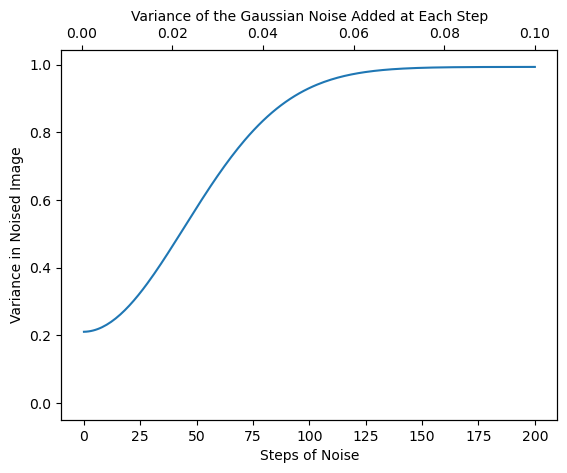

In [11]:
y_arr = np.array([])
for index, i in enumerate(range(timesteps)):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample, 0), np.array([i, ]))
    y_arr = np.append(y_arr, np.var(noisy_im.flatten()))

x_arr = np.linspace(0, timesteps, timesteps)

fig, ax1 = plt.subplots()
ax1.plot(x_arr, y_arr)
ax1.set_xlabel("Steps of Noise")
ax1.set_ylabel("Variance in Noised Image")

ax2 = ax1.twiny()
ax2.plot(beta, 0 * np.ones(timesteps), alpha = 0) # Create a dummy plot
ax2.set_xlabel("Variance of the Gaussian Noise Added at Each Step")
plt.show()

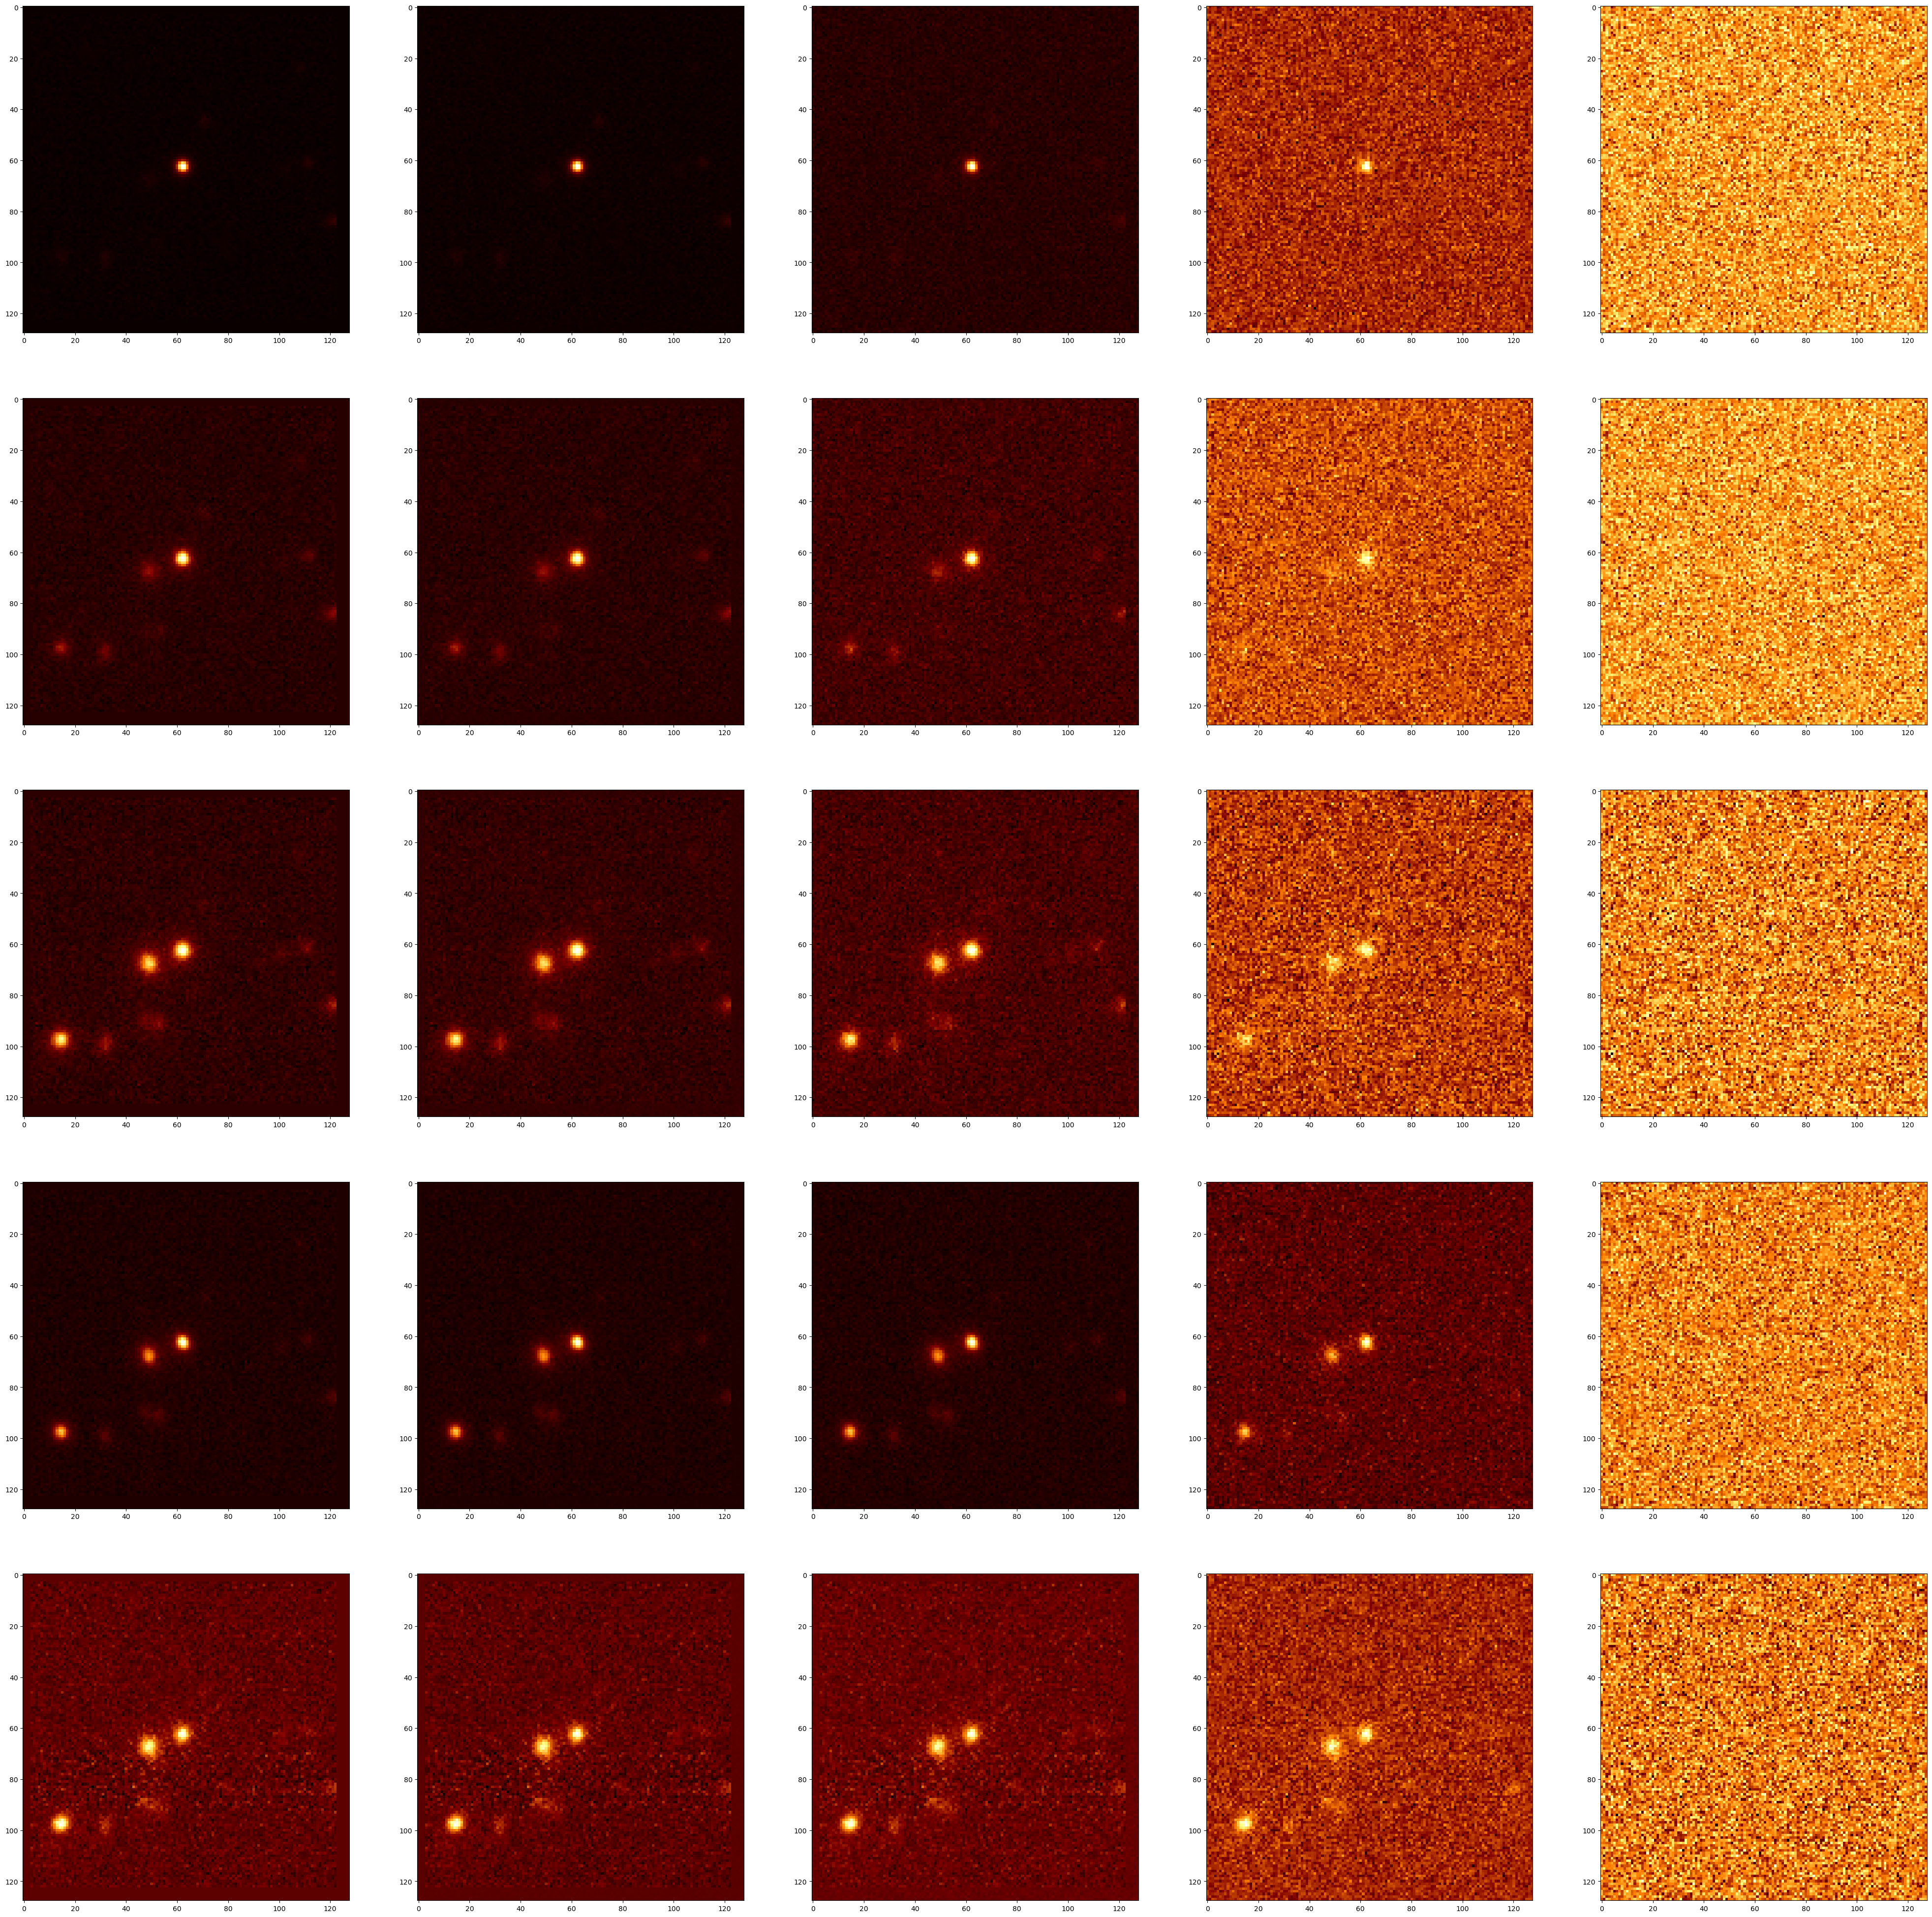

In [12]:
fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (50, 50))

j = 0

for index, i in enumerate([0, 2, 10, 50, 150]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample, 0), np.array([i, ]))
    axes[0][j].imshow(noisy_im[0][:, :, 0], cmap = 'afmhot')
    axes[1][j].imshow(noisy_im[0][:, :, 1], cmap = 'afmhot')
    axes[2][j].imshow(noisy_im[0][:, :, 2], cmap = 'afmhot')
    axes[3][j].imshow(noisy_im[0][:, :, 3], cmap = 'afmhot')
    axes[4][j].imshow(noisy_im[0][:, :, 4], cmap = 'afmhot')
    j += 1
    

plt.show()

In [13]:
print("Data Initialization Complete!")

Data Initialization Complete!


In [14]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions = 10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training = True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype = tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis = -1)

        return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training = True):
        return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training = True):
        return self.fn(x, training = training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters = dim, kernel_size = 4, strides = 2, padding = 'SAME')

def Downsample(dim):
    return nn.Conv2D(filters = dim, kernel_size = 4, strides = 2, padding = 'SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps = 1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training = True):
        var = tf.math.reduce_variance(x, axis = -1, keepdims = True)
        mean = tf.reduce_mean(x, axis = -1, keepdims = True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training = True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training = True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate = False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate = False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training = True):
        return gelu(x, self.approximate)

class MLP(Layer):
    def __init__(self, hidden_dim, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.net = Sequential([
            Rearrange('... -> ... 1'),  # expand_dims(axis=-1)
            nn.Dense(units=hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units=hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units=hidden_dim),
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)


class ValueConditioning(Layer):  # Modify class name
    def __init__(self, res, num_channels = 5):
        super().__init__()
        self.block = Sequential([
            nn.Dense(res * res * num_channels),
            SiLU(),
            nn.Reshape((res, res, num_channels))
        ])

        self.block.compile()

    def call(self, x):  # Modify method signature
        return self.block(x)

In [15]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups = 8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size = 3, strides = 1, padding = 'SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon = 1e-05)
        self.act = SiLU()


    def call(self, x, gamma_beta = None, training = True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(gamma_beta):
            gamma, beta = gamma_beta
            x = x * (gamma + 1) + beta

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim = None, groups = 8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units = dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups = groups)
        self.block2 = Block(dim_out, groups = groups)
        self.res_conv = nn.Conv2D(filters = dim_out, kernel_size = 1, strides = 1) if dim != dim_out else Identity()

    def call(self, x, time_emb = None, training = True):
        gamma_beta = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            gamma_beta = tf.split(time_emb, num_or_size_splits = 2, axis = -1)

        h = self.block1(x, gamma_beta = gamma_beta, training = training)
        h = self.block2(h, training = training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads = 4, dim_head = 127):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters = self.hidden_dim * 3, kernel_size = 1, strides = 1, use_bias = False)

        self.to_out = Sequential([
            nn.Conv2D(filters = dim, kernel_size = 1, strides = 1),
            LayerNorm(dim)
        ])

    def call(self, x, training = True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits = 3, axis = -1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h = self.heads), qkv)

        q = tf.nn.softmax(q, axis = -2)
        k = tf.nn.softmax(k, axis = -1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h = self.heads, x = h, y = w)
        out = self.to_out(out, training = training)

        return out

class Attention(Layer):
    def __init__(self, dim, heads = 4, dim_head = 127):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters = self.hidden_dim * 3, kernel_size = 1, strides = 1, use_bias = False)
        self.to_out = nn.Conv2D(filters = dim, kernel_size = 1, strides = 1)

    def call(self, x, training = True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits = 3, axis = -1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis = -1), axis = -1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis = -1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training = training)

        return out

In [16]:
class Unet_conditional(Model):
    def __init__(self,
                 dim = 128,
                 init_dim = None,
                 out_dim = None,
                 dim_mults = (1, 2, 4, 8),
                 channels = 5,
                 resnet_block_groups = 8,
                 learned_variance = False,
                 sinusoidal_cond_mlp = True,
                 class_embedder = None,
                 class_emb_dim = 64,
                 in_res = 128
                 ):
        super(Unet_conditional, self).__init__()

        # determine dimensions
        self.channels = channels
        self.in_res = in_res

        # self.class_embeddings = nn.Embedding(num_classes, class_emb_dim) if class_embedder is None else class_embedder

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        if sinusoidal_cond_mlp:
            self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                GELU(),
                nn.Dense(units=time_dim)
            ], name="time embeddings")
        else:
            self.time_mlp = MLP(time_dim)

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        now_res = in_res

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                ValueConditioning(now_res),
                block_klass(dim_in+1, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])

            now_res //= 2 if not is_last else 1

        mid_dim = dims[-1]
        self.mid_conditioning = ValueConditioning(now_res)
        self.mid_block1 = block_klass(mid_dim+1, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                ValueConditioning(now_res),
                block_klass((dim_out * 2) + 1, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

            now_res *= 2 if not is_last else 1

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")

    def call(self, x, time=None, condition_vector=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        # class_vector = self.class_embeddings(class_vector)
        
        h = []

        for conditioning, block1, block2, attn, downsample in self.downs:
            cv = conditioning(condition_vector)
            x = tf.concat([x, cv], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)
        
        cv = self.mid_conditioning(condition_vector)
        x = tf.concat([x, cv], axis=-1)
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for conditioning, block1, block2, attn, upsample in self.ups:
            cv = conditioning(condition_vector)
            x = tf.concat([x, cv], axis=-1)
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

In [17]:
# create our unet model
unet = Unet_conditional(in_res = 128, channels = 5)

# initialize the model in the memory of our GPU
test_images = np.ones([1, 128, 128, channels])
test_timestamps = generate_timestamp(0, 1)
test_condition = np.array([[1]])
k = unet(test_images, test_timestamps, test_condition)

# create our optimizer, we will use adam with a Learning rate of 1e-4
opt = keras.optimizers.Adam(learning_rate = 1e-4)

2023-07-21 06:17:58.552280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-21 06:17:59.043405: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-21 06:17:59.222290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [18]:
unet.summary()

Model: "unet_conditional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  20664     
                                                                 
 time embeddings (Sequential  (1, 512)                 328704    
 )                                                               
                                                                 
 value_conditioning (ValueCo  multiple                 163840    
 nditioning)                                                     
                                                                 
 resnet_block (ResnetBlock)  multiple                  393600    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 427008    
 )                                                               
                                                  

In [19]:
def loss_fn(real, generated, condition):
    loss = tf.reduce_mean((real - generated) ** 2)
    return loss

In [20]:
print("Network Initialization Complete!")

Network Initialization Complete!


In [21]:
def train_step(batch, condition):
    rng, tsrng = np.random.randint(0, 100000, size=(2,))
    timestep_values = generate_timestamp(tsrng, batch.shape[0])

    noised_image, noise = forward_noise(rng, batch, tf.cast(timestep_values, tf.int32))
    with tf.GradientTape() as tape:
        prediction = unet(noised_image, timestep_values, condition)
        
        loss_value = loss_fn(noise, prediction, condition)
    
    gradients = tape.gradient(loss_value, unet.trainable_variables)
    opt.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

epochs = 3

opt.learning_rate = 1e-5

for e in range(1, epochs + 1):
    bar = tf.keras.utils.Progbar(len(train_gen))
    losses = []
    for i in range(0, len(train_gen)):
        batch, condition = next_batch()
        loss = train_step(batch, condition)
        losses.append(loss)
        bar.update(i, values=[("loss", loss)])  

    avg = np.mean(losses)
    if e > 2:
        opt.learning_rate = 1e-6
    print(f"Average loss for epoch {e}/{epochs}: {avg}")

KeyboardInterrupt: 

In [ ]:
unet.save_weights('/data3/Billy/unnormalized_weights_full_quadratic_weighted_5.csv')

In [ ]:
unet.load_weights('/data3/Billy/unnormalized_weights_full_quadratic_weighted_5.csv')

In [ ]:
stop here

In [ ]:
def save_gif(img_list, path = "", interval = 200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        max = np.amax(np.nan_to_num(img_list))
        min = np.amin(np.nan_to_num(img_list))
        im = (im - min) / (max - min) * 255
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp = path, format='GIF', append_images = imgs,
             save_all = True, duration = interval, loop = 0)

In [ ]:
def ddpm(x_t, pred_noise, t):
    alpha_t = np.take(alpha, t)
    alpha_t_bar = np.take(alpha_bar, t)

    eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
    mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

    var = np.take(beta, t)
    z = np.random.normal(size=x_t.shape)

    return mean + (var ** .5) * z

In [ ]:
for k in range(0, 5):
    z = k / 2 + 0.1
    x = tf.random.normal((1, 128, 128, 5))

    img_list_g = []
    img_list_r = []
    img_list_i = []
    img_list_z = []
    img_list_y = []
    img_list_g.append(np.squeeze(x, 0)[: , : , 0])
    img_list_r.append(np.squeeze(x, 0)[: , : , 1])
    img_list_i.append(np.squeeze(x, 0)[: , : , 2])
    img_list_z.append(np.squeeze(x, 0)[: , : , 3])
    img_list_y.append(np.squeeze(x, 0)[: , : , 4])
    
    for i in tqdm(range(timesteps - 1)):
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, np.array([z]), t)
        x = ddpm(x, pred_noise, t)
        img_list_g.append(np.squeeze(x, 0)[: , : , 0])
        img_list_r.append(np.squeeze(x, 0)[: , : , 1])
        img_list_i.append(np.squeeze(x, 0)[: , : , 2])
        img_list_z.append(np.squeeze(x, 0)[: , : , 3])
        img_list_y.append(np.squeeze(x, 0)[: , : , 4])
            

    save_gif(img_list_g + ([img_list_g[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_g.gif", interval = 20)
    save_gif(img_list_r + ([img_list_r[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_r.gif", interval = 20)
    save_gif(img_list_i + ([img_list_i[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_i.gif", interval = 20)
    save_gif(img_list_z + ([img_list_z[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_z.gif", interval = 20)
    save_gif(img_list_y + ([img_list_y[-1]] * 100), f"diffusion_generations/conditional_z_{z}_band_y.gif", interval = 20)

In [ ]:
z = random.uniform(0, 4)

x = tf.random.normal((1, 128, 128, 5))

for i in tqdm(range(timesteps - 1)):
    
    t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
    pred_noise = unet(x, np.array([z]), t)
    x = ddpm(x, pred_noise, t)
    
image_g = np.squeeze(x, 0)[: , : , 0][:-1, :-1]
image_r = np.squeeze(x, 0)[: , : , 1][:-1, :-1]
image_i = np.squeeze(x, 0)[: , : , 2][:-1, :-1]
image_z = np.squeeze(x, 0)[: , : , 3][:-1, :-1]
image_y = np.squeeze(x, 0)[: , : , 4][:-1, :-1]

five_band_image = np.array([image_g, image_r, image_i, image_z, image_y])
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])

hf = h5py.File('/data3/Diffusion/127x127_diffusion_generated_7.hdf5', 'a')
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [z], chunks = True, maxshape = (None, ))

for i in range(1999):
    
    stdout.write("\rChecking %d samples of " % (i + 1) + "2000")
    
    z = random.uniform(0, 4)
    
    x = tf.random.normal((1, 128, 128, 5))
    
    for i in tqdm(range(timesteps - 1)):
        
        t = np.expand_dims(np.array(timesteps - i - 1, np.int32), 0)
        pred_noise = unet(x, np.array([z]), t)
        x = ddpm(x, pred_noise, t)
    
    image_g = np.squeeze(x, 0)[: , : , 0][:-1, :-1]
    image_r = np.squeeze(x, 0)[: , : , 1][:-1, :-1]
    image_i = np.squeeze(x, 0)[: , : , 2][:-1, :-1]
    image_z = np.squeeze(x, 0)[: , : , 3][:-1, :-1]
    image_y = np.squeeze(x, 0)[: , : , 4][:-1, :-1]
    
    five_band_image = np.array([image_g, image_r, image_i, image_z, image_y])
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image

hf.close()

In [ ]:
hf.close()

In [ ]:
print("Data Generation Complete!")

In [ ]:
# END